In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

In [5]:
data = pd.read_csv('./data/processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [6]:
feature = 'total load actual'
y = data.rolling(24*7, center=True).mean()[feature].dropna()

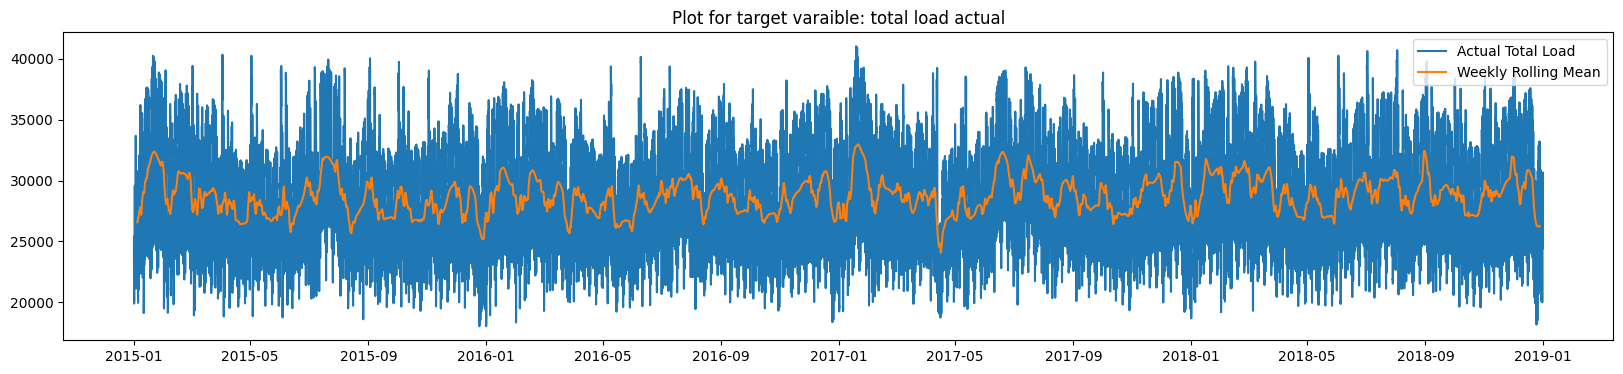

In [7]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(data[feature])
ax.plot(y)
ax.set_title("Plot for target varaible: "+feature)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(['Actual Total Load', 'Weekly Rolling Mean'])
plt.show()

## Stationary Tests

In [9]:
diff = data['total load actual'].diff().dropna()

### Augmented Dickey-Fuller (ADF) test

In [10]:
result_diff = adfuller(diff)
print(f"ADF Statistic after 1st diff: {result_diff[0]:.4f}, p-value: {result_diff[1]:.4f}")

ADF Statistic after 1st diff: -34.2917, p-value: 0.0000


Since p-value <= 0.05, ADF reject H0 and the data is likely stationary

### KPSS Test

In [11]:
diff = data['total load actual'].diff().dropna()
stat, p_value, lags, crit = kpss(diff, regression='c')

print("KPSS Statistic :", stat)
print("p-value        :", p_value)
print("lags used      :", lags)
print("critical value :", crit)

KPSS Statistic : 0.02562935109780075
p-value        : 0.1
lags used      : 1431
critical value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_77953/943923991.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, crit = kpss(diff, regression='c')


Since p-value > 0.05, KPSS fail to reject H0 and the data is likely stationary

Both tests show the data is stationary after 1st differencing and the energy consumption data is suitable for ARIMA.

### ACF and PACF Plot

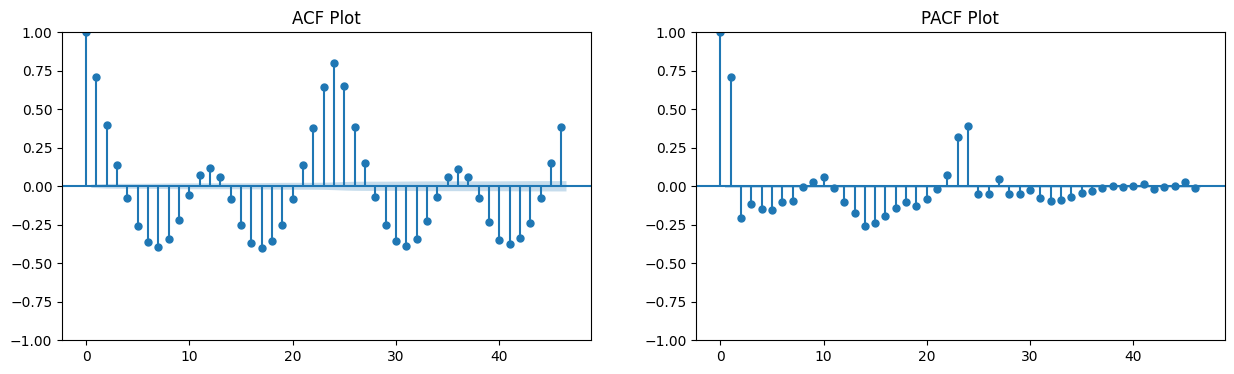

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
plot_acf(diff, ax=axes[0])
axes[0].set_title("ACF Plot")
plot_pacf(diff, ax=axes[1])
axes[1].set_title("PACF Plot")
plt.show()

## AugReg

In [13]:
y = data[feature]
train_percent = 0.8
train_size = 24*7*8
test_size = 24*7*10+1
train, test = y[:train_size], y[train_size:test_size]

In [14]:
P = 24

model = AutoReg(
    train,
    lags=24,                 
    seasonal=True,           
    period=P,
    old_names=False
)

model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:      total load actual   No. Observations:                 1344
Model:              Seas. AutoReg(24)   Log Likelihood              -10503.908
Method:               Conditional MLE   S.D. of innovations            691.296
Date:                Mon, 01 Dec 2025   AIC                          21105.817
Time:                        11:22:34   BIC                          21359.901
Sample:                    01-02-2015   HQIC                         21201.078
                         - 02-25-2015                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   133.5286    243.482      0.548      0.583    -343.687     610.744
s(2,24)                -171.9538    152.614     -1.127      0.260    -471.073     127.165
s(3,24) 

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [15]:
test_predict = model_fit.predict(start=train_size, end=test_size-1, dynamic=False)

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:441: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


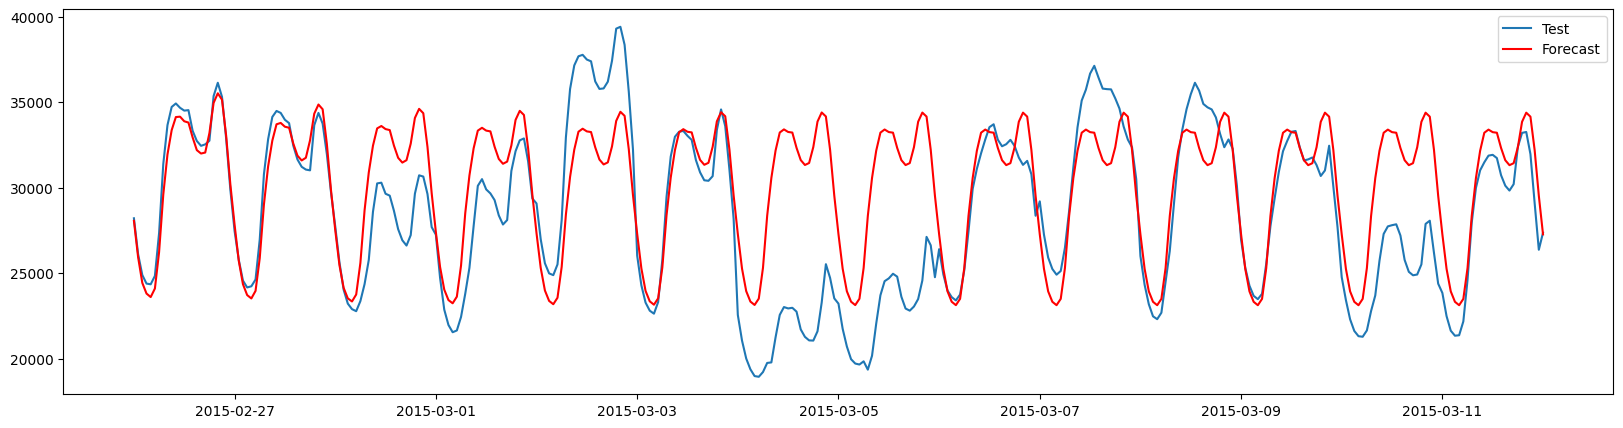

Mean Squared Error: 15361844.2405


In [16]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(test, label='Test')
plt.plot(test.index, test_predict, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, test_predict)
print(f"Mean Squared Error: {mse:.4f}")

## ARIMA

Short Period

In [18]:
y = data[feature]
train_size = 24*7*8
test_size = 24*7*10+1
train, test = y[:train_size], y[train_size:test_size]

### Manual ARIMA

In [27]:
model = ARIMA(train, order=(3, 1, 0), seasonal_order=(1, 0, 1, 24))  # p=1, d=1, q=1
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                  total load actual   No. Observations:                 1344
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 24)   Log Likelihood              -10867.116
Date:                            Mon, 01 Dec 2025   AIC                          21746.231
Time:                                    11:32:12   BIC                          21777.447
Sample:                                01-01-2015   HQIC                         21757.925
                                     - 02-25-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4811      0.011     43.133      0.000       0.459       0.503
ar.L2         -0.0880      0.023   

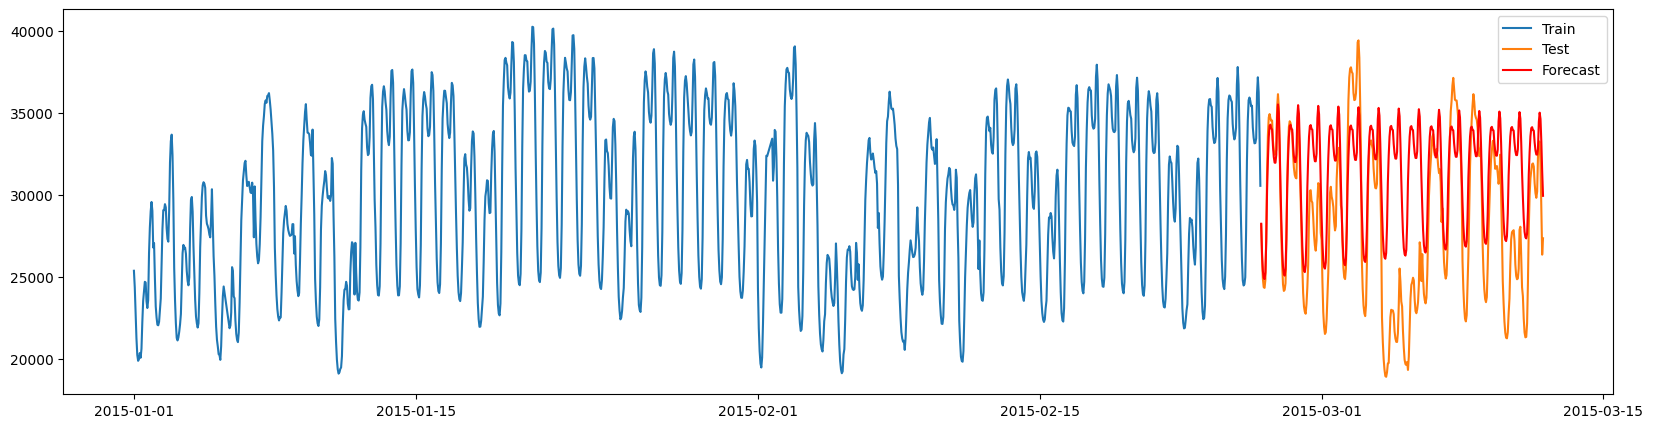

Mean Squared Error: 22477631.7232


In [28]:
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Plot
plt.figure(figsize=(20,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

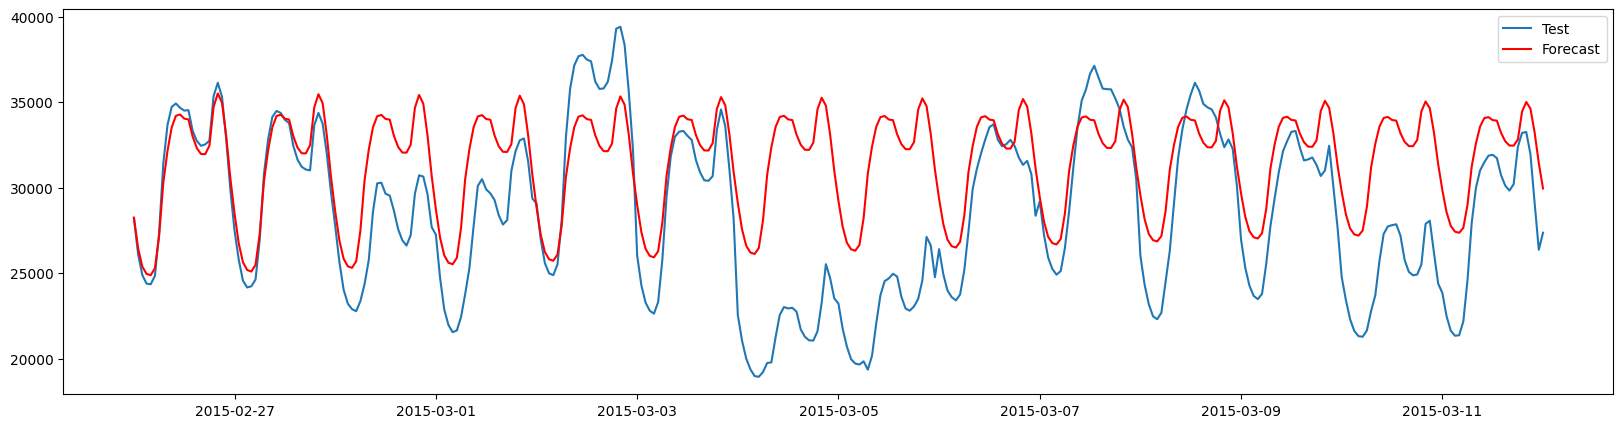

Mean Squared Error: 22477631.7232


In [29]:
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Plot
plt.figure(figsize=(20,5))
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

---

### Auto ARIMA

In [18]:
y = data[feature]
train_size = 24*8
test_size = 24*10+1
train, test = y[:train_size], y[train_size:test_size]

In [ ]:
# auto_arima will test different p,d,q combinations
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    stepwise=False,
    suppress_warnings=True,
    trace=True,
    lags=24,
    m=24,
    max_p=4,      # allow up to 8 AR terms
    max_q=4,      # allow up to 8 MA terms
    max_P=2,      # seasonal AR
    max_Q=2,      # seasonal MA
    # max_d=2,
    # max_D=1
)

print(auto_model.summary())

---

In [84]:
y = data[feature]
train_percent = 0.8
train_size = 24*8
test_size = 24*10+1
train, test = y[:train_size], y[train_size:test_size]

In [1]:
# auto_arima will test different p,d,q combinations
# auto_model = pm.auto_arima(
#     train,
#     seasonal=True,
#     stepwise=False,
#     suppress_warnings=True,
#     trace=True,
#     lags=24,
#     m=24*7,
#     max_p=4,      # allow up to 8 AR terms
#     max_q=4,      # allow up to 8 MA terms
#     max_P=2,      # seasonal AR
#     max_Q=2,      # seasonal MA
#     # max_d=2,
#     # max_D=1
# )

# print(auto_model.summary())

---

## Reload and test trained Model

In [ ]:
y = data[feature]
train_percent = 0.8
train_size = 24*7*8
test_size = 24*7*10+1
train, test = y[:train_size], y[train_size:test_size]

In [ ]:
# auto_model = pm.auto_arima(
#     train,
#     seasonal=True,
#     stepwise=False,
#     suppress_warnings=True,
#     trace=True,
#     lags=24,
#     m=24,
#     max_p=4,      
#     max_q=4,      
#     max_P=2,      
#     max_Q=2,      
#     # max_d=2,
#     # max_D=1
# )

# print(auto_model.summary())

 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=23679.448, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=22851.788, Time=1.70 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=22679.777, Time=10.23 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=22292.596, Time=1.98 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=inf, Time=25.46 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=9.78 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=25.72 sec
 ARIMA(0,1,0)(2,0,2)[24] intercept   : AIC=inf, Time=28.33 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=22909.645, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=22393.207, Time=2.70 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=22297.098, Time=15.41 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=22045.435, Time=2.66 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=21787.669, Time=6.35 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=35.32 sec
 ARIMA(0,1

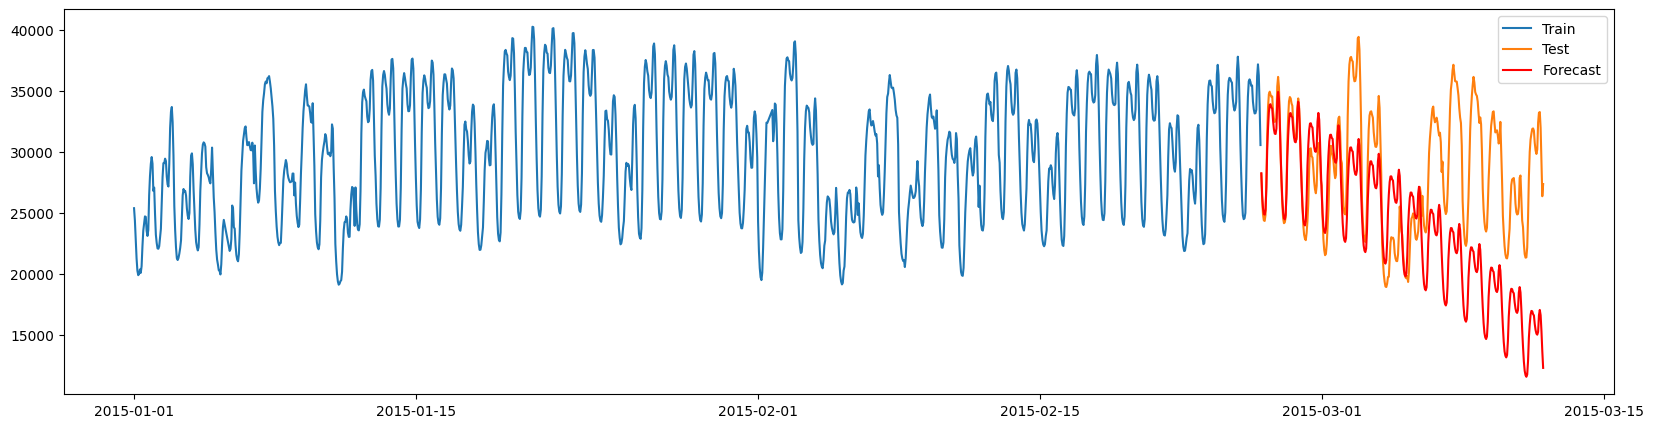

Mean Squared Error: 53811006.2367


In [74]:
import joblib

# model_params = auto_model.get_params()

# joblib.dump(auto_model, "auto_arima_2.pkl")
reloaded_model = joblib.load("auto_arima_2.pkl")
forecast = reloaded_model.predict(n_periods=len(test))

# Plot
plt.figure(figsize=(20,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluate
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

In [77]:
reloaded_model.resid()

2015-01-01 00:00:00+01:00    25549.241394
2015-01-01 01:00:00+01:00    -6597.412583
2015-01-01 02:00:00+01:00      260.877987
2015-01-01 03:00:00+01:00       97.757138
2015-01-01 04:00:00+01:00     -417.953902
                                 ...     
2015-02-25 19:00:00+01:00      623.873304
2015-02-25 20:00:00+01:00      -35.645023
2015-02-25 21:00:00+01:00     -478.635975
2015-02-25 22:00:00+01:00     -441.199650
2015-02-25 23:00:00+01:00     -376.105647
Length: 1344, dtype: float64

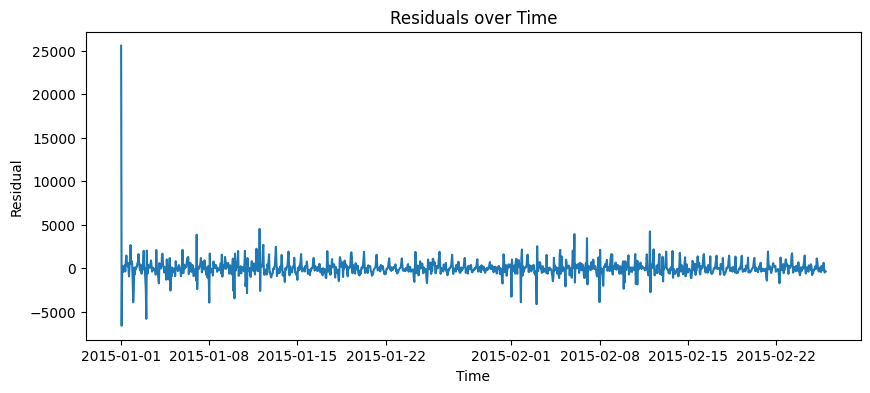

In [78]:
import matplotlib.pyplot as plt

residuals = reloaded_model.resid()  # if you used statsmodels ARIMA/SARIMA

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

In [79]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb)

      lb_stat  lb_pvalue
10  17.650165   0.061159
